<a href="https://colab.research.google.com/github/sidsanc/258_DeepLearning/blob/main/CatchUp_Assignment/Part_3/DeepFloyd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running IF with diffusers 





In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       13297192 kB


And an NVIDIA T4 with 15 GB VRAM:

In [ ]:
!nvidia-smi

Wed Apr 26 14:25:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   8677MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install dependencies 

Some optimizations can require up-to-date versions of dependencies. If you are having issues, please double check and upgrade versions.

In [ ]:
! pip install --upgrade \
  diffusers~=0.16 \
  transformers~=4.28 \
  safetensors~=0.3 \
  sentencepiece~=0.1 \
  accelerate~=0.18 \
  bitsandbytes~=0.38 \
  torch~=2.0 -q

## Accepting the license


In [ ]:
!pip install huggingface_hub --upgrade

and run the login function in a Python shell

In [ ]:
from huggingface_hub import login

login()

## 1. Text-to-image generation



### 1.1 Load text encoder


In [ ]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    subfolder="text_encoder", 
    device_map="auto", 
    load_in_8bit=True, 
    variant="8bit"
)

### 1.2 Create text embeddings


In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0", 
    text_encoder=text_encoder, # pass the previously instantiated 8bit text encoder
    unet=None, 
    device_map="auto"
)

In [ ]:
prompt = 'a photograph of an astronaut riding a horse holding a sign that says "Pixel\'s in space"'

and run it through the 8bit quantized T5 model:

In [ ]:
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

In [ ]:
del text_encoder
del pipe

In [ ]:
import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()

and run it

In [ ]:
flush()

### 1.4 Stage 1: The main diffusion process


In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
generator = torch.Generator().manual_seed(1)
image = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

  0%|          | 0/100 [00:00<?, ?it/s]

Let's manually convert the raw tensors to PIL and have a sneak peak at the final result. The output of stage 1 is a 64x64 image.

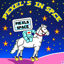

In [ ]:
from diffusers.utils import pt_to_pil

pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

And again, we remove the Python pointer and free CPU and GPU memory: 

In [ ]:
del pipe
flush()

Create the pipeline

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", 
    text_encoder=None, # no use of text encoder => memory savings!
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


and run it, re-using the pre-computed text embeddings

In [ ]:
image = pipe(
    image=image, 
    prompt_embeds=prompt_embeds, 
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

Again we can inspect the intermediate results.

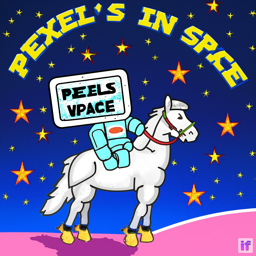

In [ ]:
pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

And again, we delete the Python pointer and free memory

In [ ]:
del pipe
flush()

### 1.6 Stage 3: Super Resolution 256x256 to 1024x1024


In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler", 
    torch_dtype=torch.float16, 
    device_map="auto"
)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
pil_image = pipe(prompt, generator=generator, image=image).images

  0%|          | 0/75 [00:00<?, ?it/s]

Unlike the IF pipelines, the IF watermark will not be added by default to outputs from the Stable Diffusion x4 upscaler pipeline.

We can instead manually apply the watermark.

In [ ]:
from diffusers.pipelines.deepfloyd_if import IFWatermarker

watermarker = IFWatermarker.from_pretrained("DeepFloyd/IF-I-XL-v1.0", subfolder="watermarker")
watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

[<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F7B899CF910>]

View output image

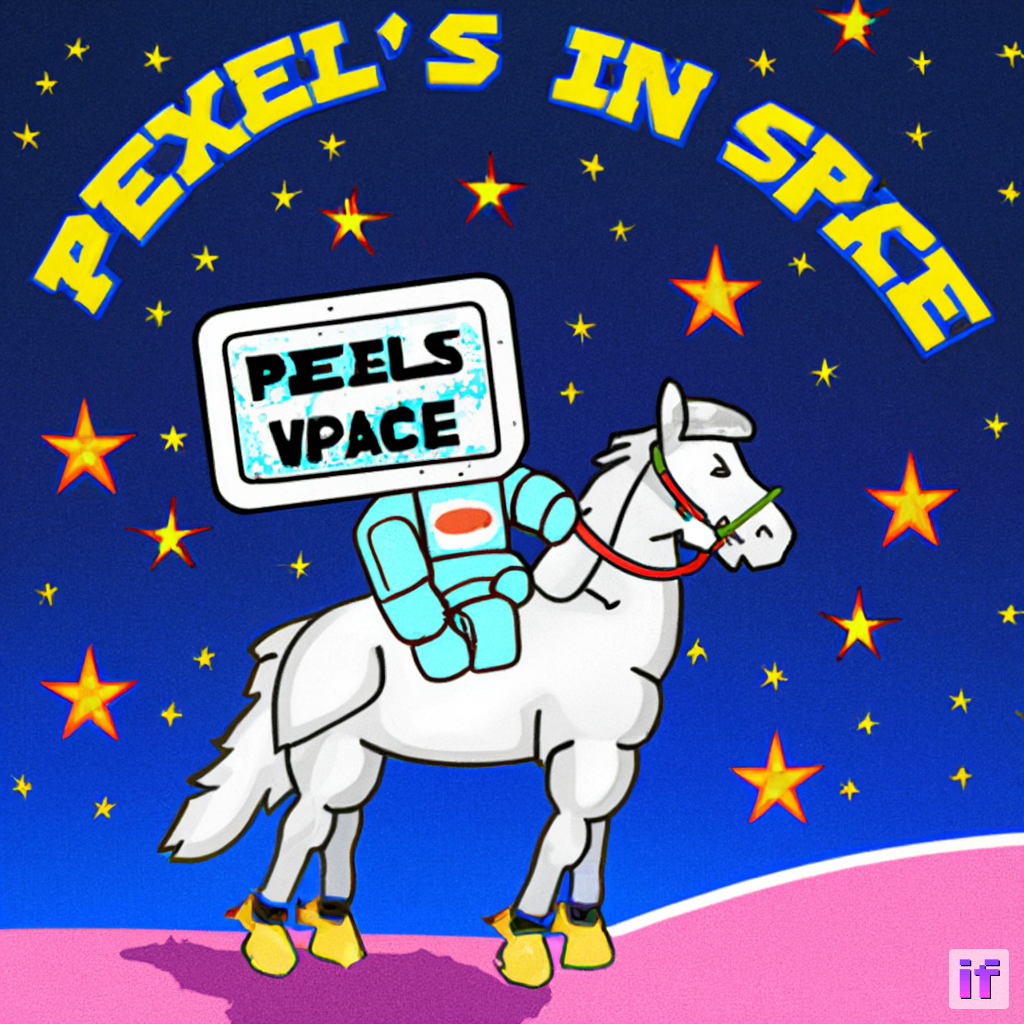

In [ ]:
pil_image[0]

## 2. Image variation


Let's free the memory from the previous section.

In [ ]:
del pipe

In [ ]:
flush()

In [ ]:
import requests

url = "https://i.kym-cdn.com/entries/icons/original/000/026/561/car.jpg"
response = requests.get(url)

and load it into a PIL Image

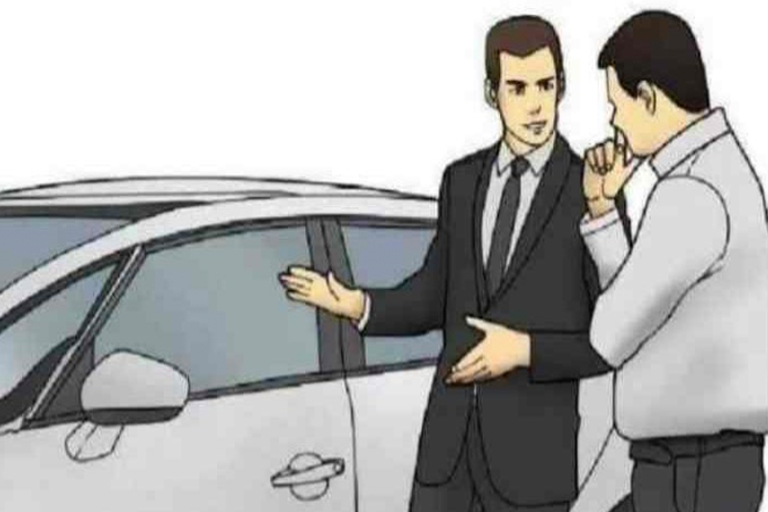

In [ ]:
from PIL import Image
from io import BytesIO

original_image = Image.open(BytesIO(response.content)).convert("RGB")
original_image = original_image.resize((768, 512))
original_image

The image variation pipeline take both PIL images and raw tensors. View the docstrings for more indepth documentation on expected inputs, [here](https://huggingface.co/docs/diffusers/v0.16.0/en/api/pipelines/if#diffusers.IFImg2ImgPipeline.__call__)

### 2.1 Text Encoder

Image variation is guided by text, so we can define a prompt and encode it with T5's Text Encoder.

Again we load the text encoder into 8bit precision.

In [ ]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    subfolder="text_encoder", 
    device_map="auto", 
    load_in_8bit=True, 
    variant="8bit"
)

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


For image variation, we load the checkpoint with [`IFImg2ImgPipeline`](https://huggingface.co/docs/diffusers/api/pipelines/if#diffusers.IFImg2ImgPipeline). When using `DiffusionPipeline.from_pretrained(...)`, checkpoints are loaded into their default pipeline. The default pipeline for the IF is the text-to-image [`IFPipeline`](https://huggingface.co/docs/diffusers/api/pipelines/if#diffusers.IFPipeline). When loading checkpoints with a non-default pipeline, the pipeline must be explicitly specified.

In [ ]:
from diffusers import IFImg2ImgPipeline

pipe = IFImg2ImgPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0", 
    text_encoder=text_encoder, 
    unet=None, 
    device_map="auto"
)

Let's turn our salesman into an anime character.

In [ ]:
prompt = "anime style"

As before, we create the text embeddings with T5

In [ ]:
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

and free GPU and CPU memory.

First remove the Python pointers

In [ ]:
del text_encoder
del pipe

and then free the memory

In [ ]:
flush()

### 2.2 Stage 1: The main diffusion process

Next, we only load the stage 1 UNet weights into the pipeline object, just like we did in the previous section.

In [ ]:
pipe = IFImg2ImgPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


In [ ]:
generator = torch.Generator().manual_seed(0)
image = pipe(
    image=original_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

  0%|          | 0/56 [00:00<?, ?it/s]

Let's check the intermediate 64x64 again.

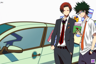

In [ ]:
pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

Looks good, we can free the memory and upscale the image again.

In [ ]:
del pipe

In [ ]:
flush()

### 2.3 Stage 2: Super Resolution

For super resolution, load the checkpoint with `IFImg2ImgSuperResolutionPipeline` and the same checkpoint as before.

In [ ]:
from diffusers import IFImg2ImgSuperResolutionPipeline

pipe = IFImg2ImgSuperResolutionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


💡 **Note**: The image variation super resolution pipeline requires the generated image as well as the original image. 

You can also use the Stable Diffusion x4 upscaler on this image. Feel free to try it out using the code snippets in section 1.6.

  0%|          | 0/40 [00:00<?, ?it/s]

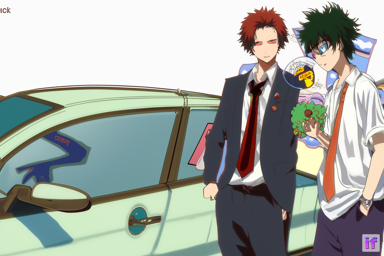

In [ ]:
image = pipe(
    image=image,
    original_image=original_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    generator=generator,
).images[0]
image

Nice! Let's free the memory and look at the final inpainting pipelines.

In [ ]:
del pipe

In [ ]:
flush()

## 3. Inpainting




First let's download the image

In [ ]:
import requests

url = "https://i.imgflip.com/5j6x75.jpg"
response = requests.get(url)

and turn it into a PIL Image

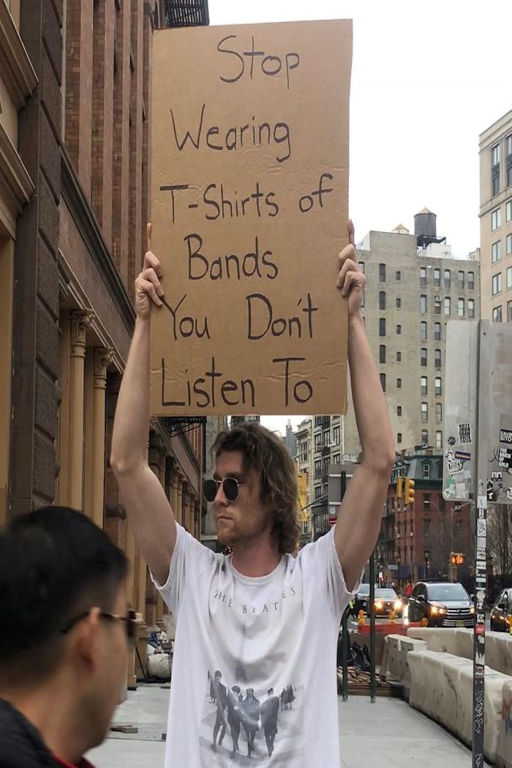

In [ ]:
from PIL import Image
from io import BytesIO

original_image = Image.open(BytesIO(response.content)).convert("RGB")
original_image = original_image.resize((512, 768))
original_image

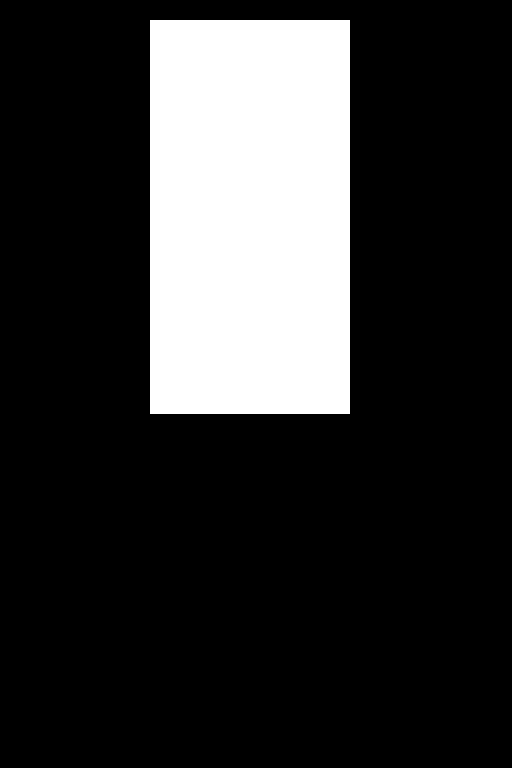

In [ ]:
from huggingface_hub import hf_hub_download

mask_image = hf_hub_download("diffusers/docs-images", repo_type="dataset", filename="if/sign_man_mask.png")
mask_image = Image.open(mask_image)

mask_image

💡 **Note**: You can create masks yourself by manually creating a greyscale image.

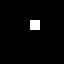

In [ ]:
from PIL import Image
import numpy as np

height = 64
width = 64

example_mask = np.zeros((height, width), dtype=np.int8)

# Set masked pixels to 255
example_mask[20:30, 30:40] = 255

# Make sure to create the image in mode 'L'
# meaning single channel grayscale
example_mask = Image.fromarray(example_mask, mode='L')

example_mask

In [ ]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0",
    subfolder="text_encoder", 
    device_map="auto", 
    load_in_8bit=True, 
    variant="8bit"
)

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


This time, we initialize the `IFInpaintingPipeline` in-painting pipeline with the text encoder weights.


In [ ]:
from diffusers import IFInpaintingPipeline

pipe = IFInpaintingPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0", 
    text_encoder=text_encoder, 
    unet=None, 
    device_map="auto"
)

Alright, let's have the man advertise for more layers instead.

In [ ]:
prompt = 'the text, "just stack more layers"'

Having defined the prompt, we can create the prompt embeddings

In [ ]:
prompt_embeds, negative_embeds = pipe.encode_prompt(prompt)

Just like before we free the memory

In [ ]:
del text_encoder
del pipe

In [ ]:
flush()

### 3.2 Stage 1: The main diffusion process

Just like before we now load the stage 1 pipeline with only the UNet.

In [ ]:
pipe = IFInpaintingPipeline.from_pretrained(
    "DeepFloyd/IF-I-XL-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Now, we need to pass the input image, the mask image, and the prompt embeddings.

In [ ]:
image = pipe(
    image=original_image,
    mask_image=mask_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    output_type="pt",
    generator=generator,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

Let's take a look at the intermediate output.

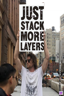

In [ ]:
pil_image = pt_to_pil(image)
pipe.watermarker.apply_watermark(pil_image, pipe.unet.config.sample_size)

pil_image[0]

Looks good! The text is pretty consistent!

Let's free the memory so we can upscale the image

In [ ]:
del pipe

In [ ]:
flush()

### 3.3 Stage 2: Super Resolution

For super resolution, load the checkpoint with `IFInpaintingSuperResolutionPipeline`.

In [ ]:
from diffusers import IFInpaintingSuperResolutionPipeline

pipe = IFInpaintingSuperResolutionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", 
    text_encoder=None, 
    variant="fp16", 
    torch_dtype=torch.float16, 
    device_map="auto"
)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


The inpainting super resolution pipeline requires the generated image, the original image, the mask image, and the prompt embeddings.

Let's do a final denoising run.

  0%|          | 0/80 [00:00<?, ?it/s]

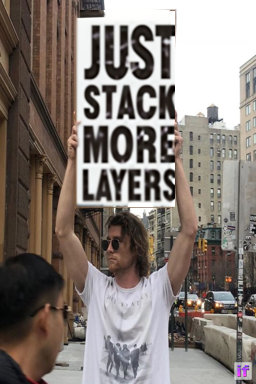

In [ ]:
image = pipe(
    image=image,
    original_image=original_image,
    mask_image=mask_image,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_embeds, 
    generator=generator,
).images[0]
image